In [1]:
from LIMxCMBL.init import *
from LIMxCMBL.noise import *

In [2]:
nbins = 100

In [3]:
# CCAT-prime
zmin = 3.5
zmax = 8.1

Omega_field = 8 * (np.pi/180)**2 #rad^2
Pei = 2.3e4 #Mpc^3 kJy^2 /sr^2 
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

[]

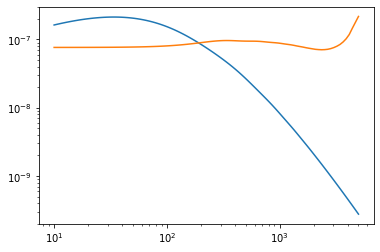

In [4]:
# get CMB lensing component
from LIMxCMBL.kernels import get_f_Kkappa
f_WkD = get_f_Kkappa()

from LIMxCMBL.cross_spectrum import *
ClKK = d_chib_integral(f_WkD, f_WkD) #[Mpc]^2


# beam=1.4, noise=7
from scipy.interpolate import interp1d
N0_ells = np.logspace(1, np.log10(5000), 500)
with open('LIMxCMBL/N0.npy', 'rb') as f:
    N0 = np.load(f)
    
f_N0 = interp1d(x = N0_ells, y = N0)

    
plt.plot(ells, ClKK)
plt.plot(ells, f_N0(ells))
plt.loglog()

In [5]:
# if no high pass IKappa
from  LIMxCMBL.kernels import *
f_KLIM   = get_f_KI()
f_Kkappa = get_f_Kkappa()

f_KLIM_windowed = apply_window(f_K = f_KLIM,
                               chimin = chimin,
                               chimax = chimax)

In [6]:
deltas.shape

(128,)

In [7]:
chi_bin_edges = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), nbins + 1)
chi_bin_centers = (chi_bin_edges[1:] + chi_bin_edges[:-1])/2
dchi_binned = np.mean(np.diff(chi_bin_edges))

In [8]:
Ik_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/Ik_zmin_%.5f_zmax_%.5f_quad_nbins_%d.npy'%(zmin, zmax, nbins)
I_kappa = np.load(Ik_fname)

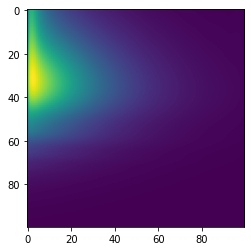

In [9]:
plt.imshow(I_kappa)

In [10]:
external_chis   = chi_bin_centers

In [11]:
from scipy.integrate import simpson, trapezoid

In [12]:
SNR2_per_mode_diag = {}
SNR2_per_mode = {}

In [13]:
from scipy.integrate import quad_vec

In [14]:
# if no high pass IKappa
from  LIMxCMBL.kernels import *
f_KLIM   = get_f_KI()
f_Kkappa = get_f_Kkappa()

f_KLIM_windowed = apply_window(f_K = f_KLIM,
                               chimin = chimin,
                               chimax = chimax)

_deltas = deltas.reshape(1, -1)

def f_Ik(chi):
    _minus = chi * (1 - _deltas)
    _plus  = chi * (1 + _deltas)

    f_Kpsi = f_KLIM_windowed
    f_Kphi = f_Kkappa

    prefactor = 2 / chi
    kernels = (f_Kpsi(_minus) * f_Kphi(_plus) + f_Kpsi(_plus) * f_Kphi(_minus))
    inner_integral_resampled = f_inner_integral(chi)
    integrand = prefactor*kernels*inner_integral_resampled*deltas_reshaped
    return trapezoid(y=integrand, x=np.log(deltas), axis = -1)

integrand =  lambda chi: (f_Ik(chi)**2 / (Pei/chi**2))[0]
no_filter_SNR2, _ = quad_vec(integrand, chimin, chimax, epsabs = 0.0, epsrel = 1e-3)
no_filter_SNR2 /= (ClKK + f_N0(ells))

SNR2_per_mode_diag[0.0] = no_filter_SNR2
SNR2_per_mode[0.0] = SNR2_per_mode_diag[0.0]

In [15]:
unfiltered_LIM_auto = np.load('/scratch/users/delon/LIMxCMBL/I_auto/I_auto_nbins_%d_zmin_%.1f_zmax_%.1f.npy'%(nbins, zmin, zmax))
print(unfiltered_LIM_auto.shape)

(100, 100, 100)


In [16]:
Lambda_idx = -1
for Lambda in tqdm(Lambdas):
    Lambda_idx += 1
    try:
        eHIeHI_oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/mpmath_comb_zmin_%.5f_zmax_%.5f_Lambda_idx_%.d_from_quad_nbins_%d.npy'%(zmin, zmax, Lambda_idx, nbins)
        eHIeHI_binned = np.load(eHIeHI_oup_fname)
        print('got it for ', Lambda_idx)
    except:
        eHIeHI_oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/comb_zmin_%.5f_zmax_%.5f_Lambda_idx_%.d_from_quad_nbins_%d.npy'%(zmin, zmax, Lambda_idx, nbins)
        eHIeHI_binned = np.load(eHIeHI_oup_fname)
    

    ILo_kappa_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/ILok_zmin_%.5f_zmax_%.5f_idx_%d_quad_nbins_%d.npy'%(zmin, zmax, Lambda_idx, nbins)
    ILo_kappa = np.load(ILo_kappa_fname)
    IHi_kappa = I_kappa - ILo_kappa
    
    print('mabs cross squared', np.max(np.abs(IHi_kappa))**2)
    
    cov = np.einsum('i, jk->ijk', (ClKK + f_N0(ells)),  Pei * eHIeHI_binned)
#     cov += np.einsum('i, ijk->ijk', (ClKK + f_N0(ells)),  unfiltered_LIM_auto)

    print('mabs cov', np.max(np.abs(cov)))
#     cov = cov + np.einsum('ij, ik -> ijk', IHi_kappa, IHi_kappa)
    cov = cov.astype(np.float64)
    cov = cov
    
    SNR2_per_mode[Lambda] = np.zeros_like(ells)
    for ell_idx in range(len(ells)):
        L = np.linalg.cholesky(cov[ell_idx])
        y = np.linalg.solve(L, IHi_kappa[ell_idx])
        x = np.linalg.solve(L.T, y)
        SNR2_per_mode[Lambda][ell_idx] = np.dot(IHi_kappa[ell_idx], x)
        
        
    eIeI = f_eIeI(chi_bin_centers, dchi_binned , Lambda = Lambda)
    cov = np.einsum('i, jk->ijk', (ClKK + f_N0(ells)),   Pei * np.diag(eIeI))
    cov = cov.astype(np.float64)
    SNR2_per_mode_diag[Lambda] = np.zeros_like(ells)
    for ell_idx in range(len(ells)):
        L = np.linalg.cholesky(cov[ell_idx])
        y = np.linalg.solve(L, IHi_kappa[ell_idx])
        x = np.linalg.solve(L.T, y)
        SNR2_per_mode_diag[Lambda][ell_idx] = np.dot(IHi_kappa[ell_idx], x)

  0%|          | 0/25 [00:00<?, ?it/s]

got it for  0
mabs cross squared 1.102883230303089e-14
mabs cov 6.2054052972323283257e-12


  8%|▊         | 2/25 [00:01<00:11,  1.99it/s]

got it for  1
mabs cross squared 1.1007252196594867e-14
mabs cov 6.20499960752374214e-12
got it for  2
mabs cross squared 1.09756163699471e-14
mabs cov 6.204405988431288476e-12


 16%|█▌        | 4/25 [00:01<00:06,  3.40it/s]

got it for  3
mabs cross squared 1.092926745027495e-14
mabs cov 6.20353866159693256e-12
got it for  4
mabs cross squared 1.0861425717813801e-14


 20%|██        | 5/25 [00:01<00:04,  4.10it/s]

mabs cov 6.2022741748872177106e-12
got it for  5
mabs cross squared 1.0762266584082534e-14
mabs cov 6.2004365697641283743e-12


 28%|██▊       | 7/25 [00:02<00:03,  4.78it/s]

got it for  6
mabs cross squared 1.0617658588763394e-14
mabs cov 6.1977786838012640308e-12
mabs cross squared 1.0407531369040005e-14
mabs cov 6.1939607979253017158e-12


 36%|███▌      | 9/25 [00:02<00:02,  5.62it/s]

got it for  8
mabs cross squared 1.0104018036345807e-14
mabs cov 6.1885300358977202715e-12
got it for  9
mabs cross squared 9.670055710839276e-15
mabs cov 6.1809030061190382706e-12


 40%|████      | 10/25 [00:02<00:02,  5.90it/s]

got it for  10
mabs cross squared 9.060566758798092e-15
mabs cov 6.170327875907830617e-12


 44%|████▍     | 11/25 [00:02<00:03,  4.41it/s]

got it for  11
mabs cross squared 8.231597429693122e-15
mabs cov 6.1556791127991780316e-12


 52%|█████▏    | 13/25 [00:03<00:03,  3.88it/s]

got it for  12
mabs cross squared 7.17286877373299e-15
mabs cov 6.1347136541779197362e-12
got it for  13
mabs cross squared 5.9515415358016414e-15
mabs cov 6.1033000382086738086e-12


 60%|██████    | 15/25 [00:03<00:02,  4.61it/s]

got it for  14
mabs cross squared 4.743723684059195e-15
mabs cov 6.0578932443839799796e-12
got it for  15
mabs cross squared 3.724241417113414e-15
mabs cov 5.9919044706063868714e-12


 68%|██████▊   | 17/25 [00:04<00:01,  5.12it/s]

got it for  16
mabs cross squared 2.8857031190138455e-15
mabs cov 5.8961504143244469196e-12
got it for  17
mabs cross squared 2.352877722483427e-15
mabs cov 5.7573824827702380382e-12


 76%|███████▌  | 19/25 [00:04<00:01,  5.17it/s]

got it for  18
mabs cross squared 2.137374054218759e-15
mabs cov 5.5567155652062045103e-12
got it for  19
mabs cross squared 1.8942122129042274e-15
mabs cov 5.3404616496944225605e-12


 84%|████████▍ | 21/25 [00:05<00:00,  4.92it/s]

got it for  20
mabs cross squared 1.6088139103905172e-15
mabs cov 5.07509237678242095e-12
got it for  21
mabs cross squared 1.2905542884679336e-15
mabs cov 4.6758263475979269707e-12


 88%|████████▊ | 22/25 [00:05<00:00,  3.67it/s]

got it for  22
mabs cross squared 9.90228790336779e-16
mabs cov 4.0820928526814227105e-12


 96%|█████████▌| 24/25 [00:05<00:00,  4.26it/s]

got it for  23
mabs cross squared 1.0332643028860503e-15
mabs cov 3.2723078504508937301e-12
got it for  24
mabs cross squared 1.207668195884691e-15
mabs cov 2.2688413477469402964e-12


100%|██████████| 25/25 [00:06<00:00,  4.05it/s]


In [17]:
SNR2_per_mode_full = {}
SNR2_per_mode_full[0.0] = SNR2_per_mode_diag[0.0] * Pei

Lambda_idx = -1
for Lambda in tqdm(Lambdas):
    Lambda_idx += 1
    try:
        computed_oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/snr_per_mode_scipy_zmin_%.5f_zmax_%.5f_Lambda_idx_%d_log2_%d'%(zmin, zmax, Lambda_idx, 13)
        oup1_fname = computed_oup_fname + '_full.npy'
        oup2_fname = computed_oup_fname + '_diag.npy'
        SNR2_per_mode_full[Lambda]   = np.load(oup1_fname)
    except:
        print('skipping', Lambda_idx, Lambda)

100%|██████████| 25/25 [00:00<00:00, 867.42it/s]

skipping 16 0.004641588833612777
skipping 17 0.006812920690579608
skipping 18 0.01
skipping 19 0.01467799267622069
skipping 20 0.021544346900318822
skipping 21 0.03162277660168379
skipping 22 0.046415888336127774
skipping 23 0.06812920690579609
skipping 24 0.1


In [18]:
Lambdas = np.array(sorted(list(SNR2_per_mode.keys())))

In [19]:
rainbow_colors = plt.cm.rainbow(np.linspace(0, 1, len(SNR2_per_mode_diag)))
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=rainbow_colors[::-1])

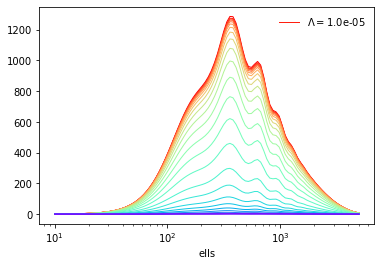

In [20]:
plt.figure(facecolor = 'w')
for Lambda in Lambdas:
    label = None
    if(Lambda == 1e-5 or Lambda == 1e0):
        label = r'$\Lambda=$%.1e'%(Lambda)
    plt.plot(ells, ells**2 * SNR2_per_mode_diag[Lambda], label=label, lw = 1)

plt.xscale('log')
plt.xlabel('ells')
plt.legend(frameon=False)

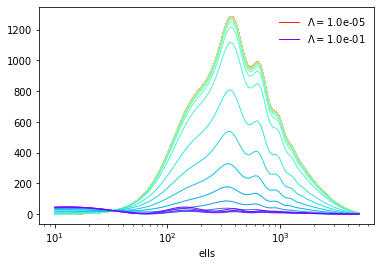

In [21]:
plt.figure(facecolor = 'w')
for Lambda in Lambdas:
    label = None
    if(Lambda == 1e-5 or Lambda == 1e-1):
        label = r'$\Lambda=$%.1e'%(Lambda)
    plt.plot(ells, ells**2 * SNR2_per_mode[Lambda], label=label, lw = 1)

plt.xscale('log')
plt.xlabel('ells')
plt.legend(frameon=False)

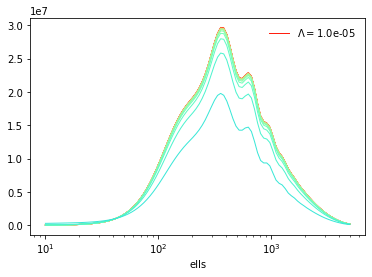

In [22]:
plt.figure(facecolor = 'w')
for Lambda in SNR2_per_mode_full:
    label = None
    if(Lambda == 1e-5 or Lambda == 1e0):
        label = r'$\Lambda=$%.1e'%(Lambda)
    plt.plot(ells, ells**2 * SNR2_per_mode_full[Lambda], label=label, lw = 1)

plt.xscale('log')
plt.xlabel('ells')
plt.legend(frameon=False)

In [23]:
plt.show()
plt.rcParams['text.usetex'] = True

In [24]:
asdf = np.where(ells > 100)

In [25]:
SNR2_per_Omega_per_invPei_full = np.zeros(len(SNR2_per_mode_full), dtype = np.float64)
for Lambda_idx in range(len(SNR2_per_mode_full)):
    Lambda = Lambdas[Lambda_idx]    
    SNR2_per_Omega_per_invPei_full[Lambda_idx] = trapezoid(x = np.log(ells), 
                                           y = SNR2_per_mode_full[Lambda] * ells ** 2 / 2 / np.pi)

In [26]:
SNR2_per_Omega_diag = np.zeros(len(SNR2_per_mode_diag))
SNR2_per_Omega = np.zeros(len(SNR2_per_mode))

for Lambda_idx,Lambda in enumerate(Lambdas):
    SNR2_per_Omega_diag[Lambda_idx] = trapezoid(x = np.log(ells), 
                                                           y = SNR2_per_mode_diag[Lambda] * ells ** 2 / 2 / np.pi)
    SNR2_per_Omega[Lambda_idx] = trapezoid(x = np.log(ells), 
                                                           y = SNR2_per_mode[Lambda] * ells ** 2 / 2 / np.pi)

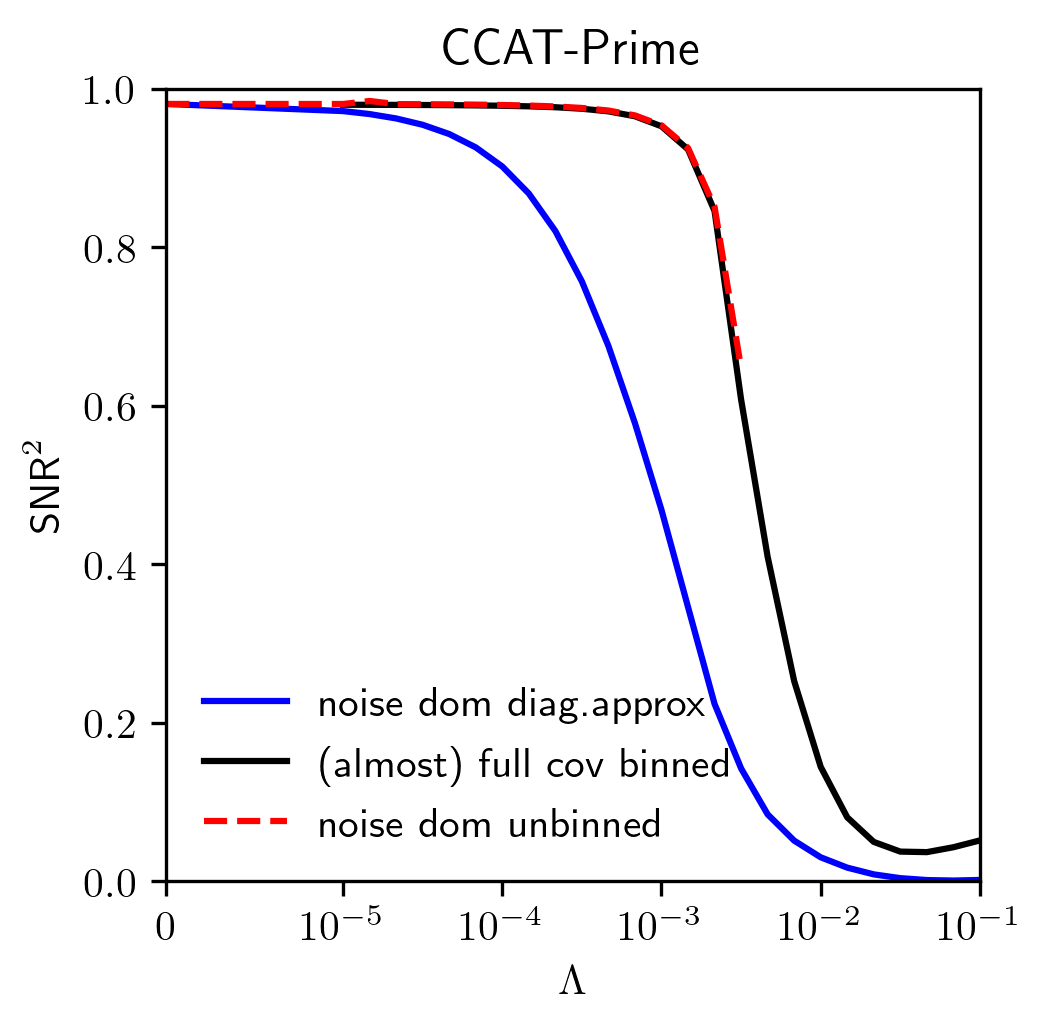

In [27]:
plt.figure(figsize = (3.5,3.5) ,dpi = 300, facecolor = 'w')


plt.plot(SNR2_per_mode_diag.keys(), (SNR2_per_Omega_diag * Omega_field), 
         c='b',
        label='noise dom diag.approx')



plt.plot(Lambdas[1:], (SNR2_per_Omega * Omega_field)[1:], 
         'k',
        label='(almost) full cov binned')

plt.plot(SNR2_per_mode_full.keys(), (SNR2_per_Omega_per_invPei_full * Omega_field / Pei), 
         'r--',
        label='noise dom unbinned')

plt.xscale('symlog', linthresh = 1e-5)
fundamental = 2*np.pi/(chimax - chimin)
plt.xlim(0, 1e-1)
plt.ylim(0, 1)
plt.xlabel(r'$\Lambda$')
plt.ylabel(r'$${\sf SNR}^2$$')
plt.title('CCAT-Prime')

plt.legend(frameon=False)